In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Mar  4 14:52:43 2020
@author: nooryoussef

Ploting a single trajectory of stokes and anti-stokes over time
"""
import numpy as np
import pandas as pd
import misc_functions as mf
import evolve_functions as ef
import matplotlib.pyplot as plt
from sklearn import linear_model
plt.style.use('seaborn-talk')

In [4]:
def load_rsts(protein, Ne, trial): 
    '''
        loads the results files
    '''
    main_rst  = pd.read_csv("../output/" + protein + '_' + Ne + '_t' + trial + '_nsubs_5e2_main_rst_diff_eq_seq.txt', 
                delimiter = " ")
    ss_freq   = np.load("../output/" + protein + '_' + Ne + '_t' + trial + '_nsubs_5e2_ssfreq.npy')  #(sub, site, aa)
    ssF       = np.load("../output/" + protein + '_' + Ne + '_t' + trial + '_nsubs_5e2_ssF_diff_eq_seq.npy')  #(sub, site, aa)
    ssdG      = np.load("../output/" + protein + '_' + Ne + '_t' + trial + '_nsubs_5e2_ssdG_diff_eq_seq.npy') #(sub, site, aa)
    
    with open("../data/eq_seqs/" + protein + "/" + protein + "_equilibrium_cdn_seq_t" + str(trial) + ".txt") as file:
        start_seq = file.readline().strip()
    
    return (main_rst, ssF, ssdG, ss_freq, start_seq)

def load_protein_specific_mutation_model(protein): 
    if protein == '1qhw':
        pi_nuc = [0.19675, 0.31761, 0.28032, 0.20532] #['T' ,'C' ,'G' ,'A'] 
        GTR = ef.mutation_matrix(pi_nuc, 4.49765,1,1,1,1,4.49765)
        
    elif protein == '2ppn':
        pi_nuc = [0.19246, 0.24559, 0.29365, 0.26830]
        GTR = ef.mutation_matrix(pi_nuc, 2.50275 ,1,1,1,1,2.50275)
        
    elif protein == '1pek':
        pi_nuc = [0.20853, 0.34561, 0.25835, 0.18750]
        GTR = ef.mutation_matrix(pi_nuc, 0.90382 ,1,1,1,1, 0.90382)
    return (GTR)


def sim_sequences(main_rst, start_seq):
    '''
        creates an array of the amino acid index sequences realized during simulation
    '''
    seq = mf.Codon_to_AA(mf.Codon_to_Cindex(start_seq))# translate codon sequence to amino acid idx sequence
    
    num_subs = len(main_rst['num_sub'])
    num_sites = len(seq)
    sequences = np.zeros((num_subs, num_sites))

    sequences[0] = seq
    for sub in range(1, num_subs):
        site =  int(main_rst['site'][sub])
        aa  = int(mf.AminoAcid[main_rst['new_aa'][sub]])
        
        seq[site] = aa
        sequences[sub] = seq
        
    return sequences

def create_dataframe(aa_sequences):
    '''
       creates a dataframe specifying for each site the resident aa's and 
       the respective residence times (first and last substituion when the amino acid was resident) 
    '''
    num_subs, num_sites = aa_sequences.shape
    sites = []; aas = []; start_sub = []; stop_sub = []
    for site in range(num_sites):
        r_aa = aa_sequences[0, site]
        s_sub = 0
        
        for sub in range(num_subs):
            n_aa = aa_sequences[sub, site]
            
            if r_aa != n_aa:
                sites.append(site); aas.append(int(r_aa)); start_sub.append(s_sub); stop_sub.append(sub -1)
                s_sub = sub
                r_aa = n_aa
        
        sites.append(site); aas.append(int(r_aa)); start_sub.append(s_sub); stop_sub.append(sub)
        
    data = {'site' : sites, 'res_aa': aas, 'start_sub': start_sub, 'stop_sub': stop_sub}
    df = pd.DataFrame(data)
    return(df)

def get_predicted_y(x, y):
    X = np.array(x).reshape(-1, 1)
    Y = np.array(y).reshape(-1,1)
    lm = linear_model.LinearRegression()
    model = lm.fit(X,Y)
    Y_pred= lm.predict(X)
    return(Y_pred)

    
def plotting_0subs_1aa(site, df, ss_freq, lm, ax):
    aa_1   = list(df.loc[df['site'] == site]['res_aa'])[0]    # amino acid
    is_1   = list(df.loc[df['site'] == site]['start_sub'])[0] # initial substituion 
    ls_1   = list(df.loc[df['site'] == site]['stop_sub'])[0]  # last subsittiion
    
    x_1 = [x for x in range(is_1, ls_1)]
    y_1 = ss_freq[is_1: ls_1, site, aa_1]

    # plot amino acids  stationary freq
    ax.plot(x_1, y_1, '-', c = 'k', label = "$\pi_a^h$", linewidth = 2)
    
    # label the resident amino acid 
    ax.text(is_1 -20, 1.1, "".join([idx for idx in mf.AminoAcid if mf.AminoAcid[idx] == aa_1]), fontsize = 18, color = 'k')
    ax.set_ylim(0,1.05)
    ax.text(1, 1, 'site = ' + str(site),
        horizontalalignment='right',
        verticalalignment='bottom',
         transform=ax.transAxes)
    if lm: 
        #  linear regressions
        y1_pred = get_predicted_y(x_1, y_1)        
        ax.plot(x_1, y1_pred, color='k', lw = 2)
        
def cdn_sim_sequences(main_rst, start_seq):
    '''
        creates an array of the CODON index sequences realized during simulation
    '''
    seq = list(mf.Codon_to_Cindex(start_seq))# translate codon sequence to amino acid idx sequence
    
    num_subs = len(main_rst['num_sub'])
    num_sites = len(seq)
    sequences = np.zeros((num_subs, num_sites))

    sequences[0] = seq
    for sub in range(1, num_subs):
        site =  int(main_rst['site'][sub])
        cdn  = mf.Codon_to_Cindex(main_rst['new_codon'][sub])[0]
        
        seq[site] = cdn
        sequences[sub] = seq
        
    return sequences

def Q_seq_all_substitutions(ssF, cdn_sequences, GTR):
    num_subs, num_sites = ssF.shape[0:2]
    
    Q_full = np.zeros((num_subs, num_sites, 61))
    for sub in range(num_subs):
        current_seq = cdn_sequences[sub]
        fit_all_sites = ssF[sub]
        
        Q_seq = ef.full_transition_vector(current_seq, fit_all_sites, 10, Ne[1], GTR)
        Q_full[sub] = Q_seq
    return(Q_full)


def hazard_function(site, ssF, Q_full, aa_sequences, GTR):
    '''
        returns the expected rate of amino acid replacment at specified site over all background sequences 
        realized during simulaiton 
        
        site: site of interest 
        ssF [num_subs x sites x 20]: site-specific amino acid fitness vector at all sites 
        _sequences [num_subs x sites]: the codon or amino acid sequences realized during simulation 
    '''
    num_subs = len(ssF)
    H = np.zeros(num_subs)
    
    for sub in range(num_subs):    
        #transition vector
        Q_seq = Q_full[sub]
        
        #convert to probabilities 
        #P_seq = (Q_seq / np.sum(Q_seq))

        #identify nonsynoymous transitions
        aa = aa_sequences[sub, site] #res amino acid
        syn_cdns = mf.aa_syn_cdns[aa] #synonymous codons 
        nonsyn_cdns = [x for x in range(61) if x not in syn_cdns] #nonsynonymous codons
        
        #probability of amino acid replacment 
        #h = np.sum(P_seq[site, nonsyn_cdns]) #sum over prob of transition to nonsyn codons
        h = np.sum(Q_seq[site, nonsyn_cdns])
        H[sub] = h
    return(H)

In [5]:
protein  = '1pek'
num_sites = 279
trial = str(148)
Ne = ('Ne2', 1e2)

#  load  files
main_rst, ssF, ssdG, ss_freq, start_seq = load_rsts(protein, Ne[0], trial)
aa_sequences = sim_sequences(main_rst, start_seq)
df = create_dataframe(aa_sequences)
cdn_sequences = cdn_sim_sequences(main_rst, start_seq)

GTR = load_protein_specific_mutation_model(protein)
Q_full = Q_seq_all_substitutions(ssF, cdn_sequences, GTR)

In [6]:
Stokes_site = 232
antiStokes_site = 72
other_site = 88

H_stokes_site     = hazard_function(Stokes_site, ssF, Q_full, aa_sequences, GTR)
H_antistokes_site = hazard_function(antiStokes_site, ssF, Q_full, aa_sequences, GTR)
H_other_site      = hazard_function(other_site, ssF, Q_full, aa_sequences, GTR)

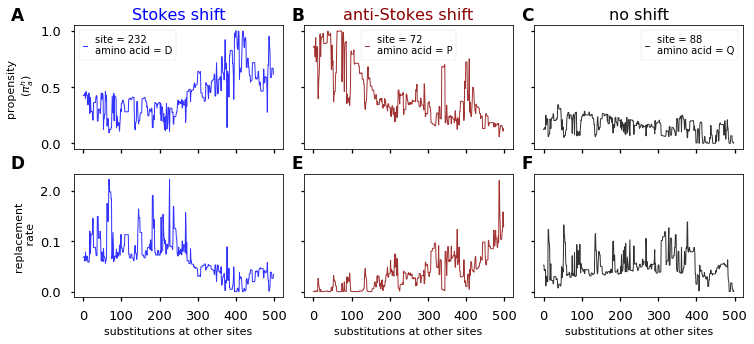

In [8]:
#%%  single site plot
plt.style.use('seaborn-talk')

f, ((ax1,ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, sharey = 'row', sharex= True, figsize= (12,5))

## Subplots A and B ## 

#resident amino acids 
a_1 = int(aa_sequences[0, Stokes_site])
a_2 = int(aa_sequences[0, antiStokes_site])
a_3 = int(aa_sequences[0, other_site])

# stationary frequencies
x = [x for x in range(499)]
y_1 = ss_freq[1: 500, Stokes_site, a_1]
y_2 = ss_freq[1: 500, antiStokes_site, a_2]
y_3 = ss_freq[1: 500, other_site, a_3]


#plot
ax1.plot(x, y_1, '-', c = 'blue', alpha = 0.8, linewidth = 1, 
         label = 'site = ' + str(Stokes_site) + "\n" +
         "amino acid = " + "".join([idx for idx in mf.AminoAcid if mf.AminoAcid[idx] == a_1]) )

ax2.plot(x, y_2, '-', c = 'darkred',  alpha = 0.8, linewidth = 1, 
        label = 'site = ' + str(antiStokes_site) + "\n" +
         "amino acid = " + "".join([idx for idx in mf.AminoAcid if mf.AminoAcid[idx] == a_2]))

ax3.plot(x, y_3, '-', c = 'k',  alpha = 0.8, linewidth = 1, 
        label = 'site = ' + str(other_site) + "\n" +
         "amino acid = " + "".join([idx for idx in mf.AminoAcid if mf.AminoAcid[idx] == a_3]))


## Subplots C and D ##
# rate of replacement
x = [x for x in range(499)]
y_1 = H_stokes_site[1:500]
y_2 = H_antistokes_site[1:500]
y_3 = H_other_site[1:500]


#plot
ax4.plot(x, y_1, '-', c = 'blue', alpha = 0.8, linewidth = 1)
ax5.plot(x, y_2, '-', c = 'darkred',  alpha = 0.8, linewidth = 1)
ax6.plot(x, y_3, '-', c = 'k',  alpha = 0.8, linewidth = 1)


#titles 
ax1.set_title("Stokes shift", c = 'blue', fontsize = 16)
ax2.set_title("anti-Stokes shift", c = 'darkred', fontsize = 16)
ax3.set_title("no shift", c = 'k', fontsize = 16)


#legends
ax1.legend(handlelength=.4, fontsize = 10, fancybox = True)
ax2.legend(handlelength=.4, fontsize = 10, fancybox = True)
ax3.legend(handlelength=.4, fontsize = 10, fancybox = True)


#ylabels
ax1.set_ylabel("propensity \n ($\pi_a^h$)", fontsize = 11)
ax4.set_ylabel("replacement \n rate", fontsize = 11)

#xlabels
ax4.set_xlabel("substitutions at other sites", fontsize = 11)
ax5.set_xlabel("substitutions at other sites", fontsize = 11)
ax6.set_xlabel("substitutions at other sites", fontsize = 11)


#limits 
ax4.set_xticks([0, 100, 200, 300, 400, 500])
ax5.set_xticks([0, 100, 200, 300, 400, 500])
ax6.set_xticks([0, 100, 200, 300, 400, 500])

plt.yticks([0, 1.0, 2.0], ["0.0", "0.1", "2.0"])
ax1.set_yticks([0, 0.5, 1.0])


#subplot labels 
ax1.text(-0.3,  1.15, "A", transform=ax1.transAxes, fontsize=17, fontweight='bold', va='top')
ax2.text(-0.06, 1.15, "B", transform=ax2.transAxes, fontsize=17, fontweight='bold', va='top')
ax3.text(-0.06, 1.15, "C", transform=ax3.transAxes, fontsize=17, fontweight='bold', va='top')

ax4.text(-0.3,  1.15, "D", transform=ax4.transAxes, fontsize=17, fontweight='bold', va='top')
ax5.text(-0.06, 1.15, "E", transform=ax5.transAxes, fontsize=17, fontweight='bold', va='top')
ax6.text(-0.06, 1.15, "F", transform=ax6.transAxes, fontsize=17, fontweight='bold', va='top')


plt.subplots_adjust(wspace=0.1, hspace=0.2)
#plt.savefig('../figures/Figure1_' +protein+'_t'+trial+'_new.png', dpi = 450)